In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from joblib import dump, load
%matplotlib inline

plt.style.use('seaborn')

In [14]:
month = 'nov'
print(month)

# read saved dataset.
df_normalized = pd.read_csv(f'data/normalized_{month}.csv')
df_normalized = df_normalized.drop(columns=['Unnamed: 0'])
df_normalized.head()

# get groups and keys on dataset.

new_groups = df_normalized.groupby('meterid')
new_keys = new_groups.groups.keys()  # keys: an iterable of dataids or meter ids

new_id_list = list(new_keys)
display('number of valid meterids:', len(new_id_list))

nov


'number of valid meterids:'

118

## LinearRegression and SVR

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import math

### Normal (naive train-test split) Validation

In [88]:
def normal_valid(model=None, meterid=35, show_plot=False, train_size=0.8):
    df_i = new_groups.get_group(meterid)

    # zoom in on specified time period.
    #df_i = zoom(df_i, origin_date, end_date)

    # convert DateTimeIndex to numerical values (ints) for regression.
    X = np.arange(start=0, stop=len(df_i.index), step=1).reshape(-1, 1)
    y = df_i['norm_cumul_value']
    #y = df_i['marginal_change']

    # split dataset
    test_start = int(len(df_i)*train_size)  
    x_train, x_test = X[:test_start,:], X[test_start:,:]
    y_train, y_test = y[:test_start], y[test_start:]

    model.fit(x_train, y_train)
    dump(lr_model, f'models/lr_{month}_{meterid}.joblib') # save model to hard disk.

    # record coefficients
    coeffs.append((lr_model.intercept_, lr_model.coef_))

    #run predictions and get scores
    y_train_pred = lr_model.predict(x_train)
    r2_train = lr_model.score(x_train, y_train)

    y_test_pred = lr_model.predict(x_test)
    r2_test = lr_model.score(x_test, y_test)

    # record scores
    scores.append((r2_train, r2_test))

    # show residual plots and prediction error plots.
    if show_plot: 
        #TODO: plot both plots side by side.
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

        # plot trendline and actual line.
        axes[0].set_title(f'cum. readings for meterid {meterid}; r2_train:{r2_train:.3f}; r2_test:{r2_test:.3f}')
        axes[0].set_xlabel(f'hours elapsed since {df_i["index"].iloc[0]}') 

        axes[0].plot(x_train, y_train, label='actual train')
        axes[0].plot(x_train, y_train_pred, label='prediction on train')

        axes[0].plot(x_test, y_test, label='actual test')
        axes[0].plot(x_test, y_test_pred, label='prediction on test')

        axes[0].legend()

        # plot prediction error plot (actual vs predicted value)
        axes[1].set_title(f'meterid {meterid} actual vs pred')
        axes[1].set_ylabel(f'actual') 
        axes[1].set_xlabel(f'pred') 

        actual = []
        actual.extend(y_train)
        actual.extend(y_test)

        predicted = []
        predicted.extend(y_train_pred)
        predicted.extend(y_test_pred)

        axes[1].scatter(y=actual, x=predicted, color='magenta', label='actual vs pred')
        axes[1].plot(actual, actual, label='perfect fit')

        axes[1].legend()

        plt.show()

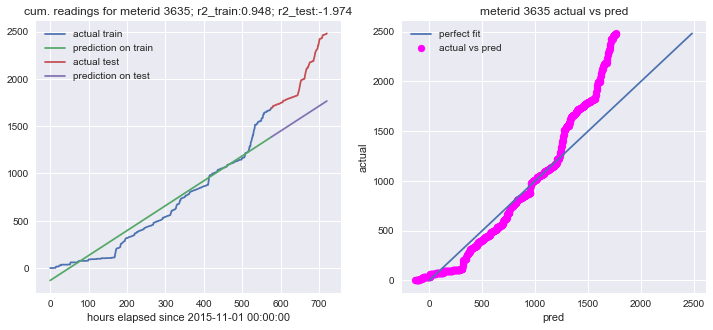

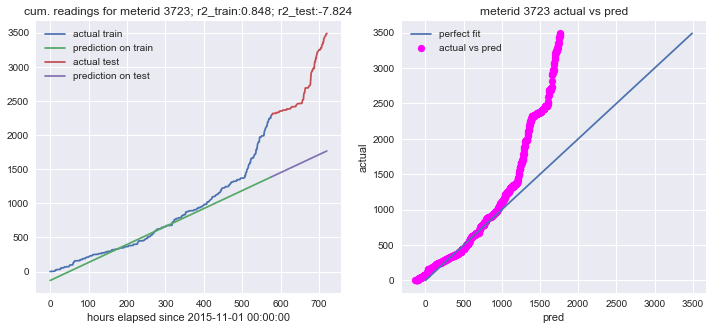

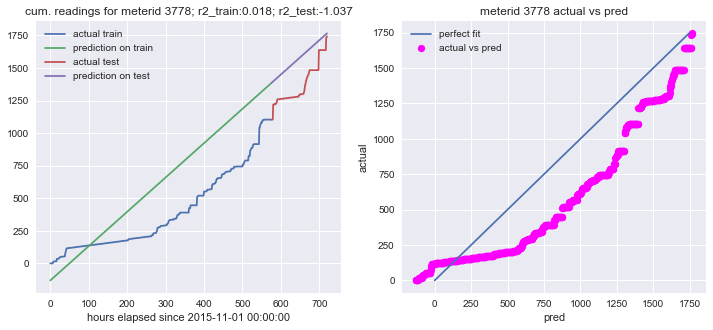

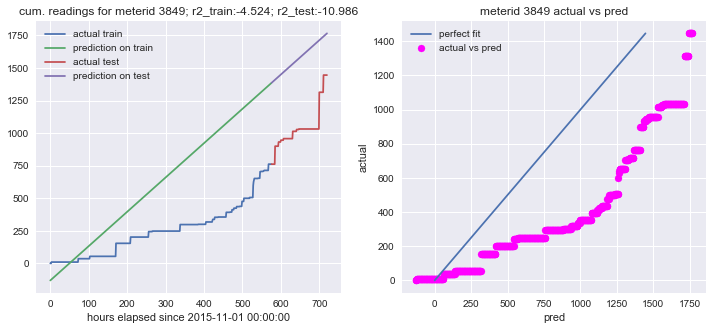

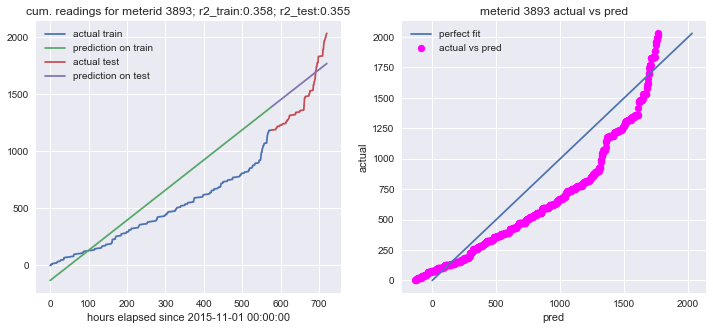

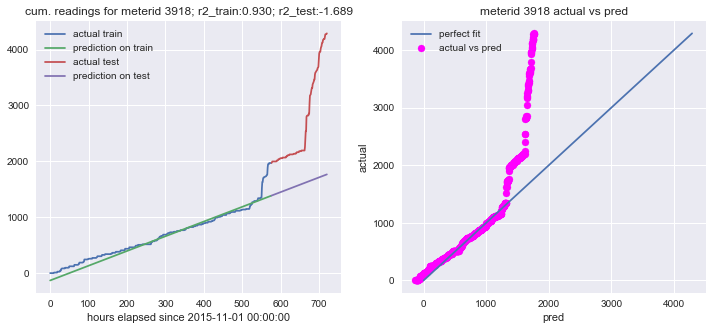

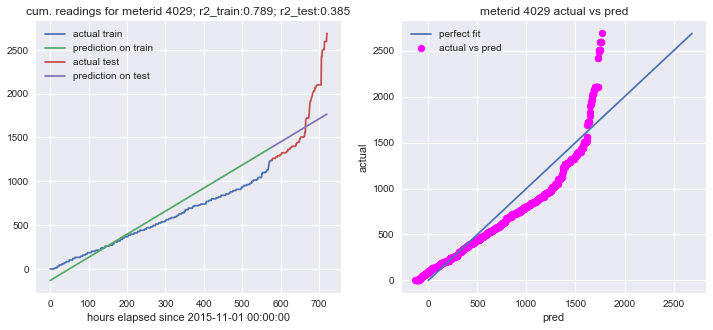

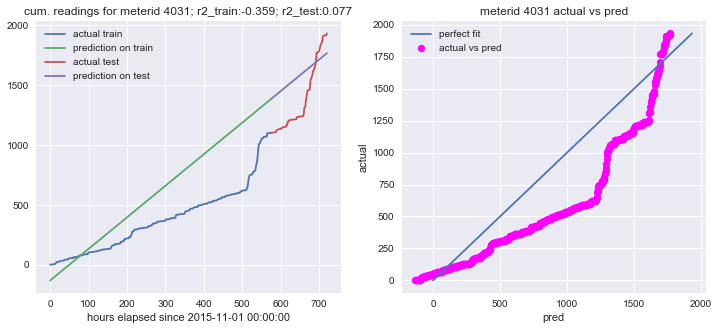

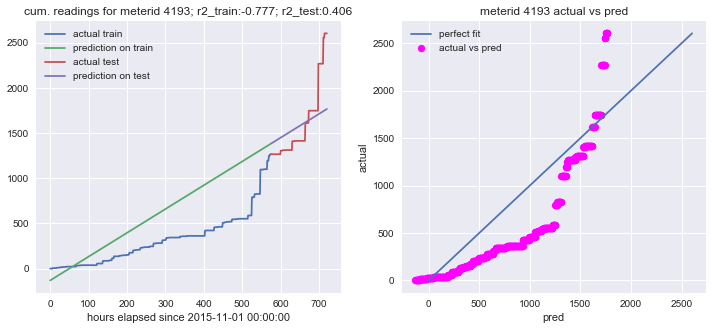

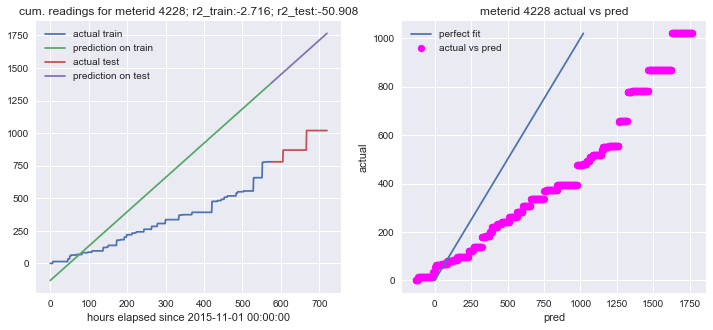

In [89]:
coeffs = []
scores = []

for meterid in new_id_list[50:60]:
    #model = LinearRegression()
    #model = Lasso(alpha=1e-4, max_iter = 1e6, tol = 0.0040)
    model = SVR(C=1159, gamma='scale', kernel='rbf')
    normal_valid(model=model, meterid=meterid, show_plot=True, train_size=0.8)

In [75]:
len(x_train)

576

### Walk-forward Validation

It is clear from the single linear regression model that predictions tend to get more inaccurate the further we go into the test period. To address this problem, we can 'update' the model by training the model on new data at every time step that it is available. 

We have chosen to go for a ROLLING walk-forward validation as it better accounts for seasonality.
The walk-forward validation approach trains on the most recent N observations and predicts on the next time step.

In [76]:
def split_data(origin_date=None, end_date=None, meterid=35, train_size=0.8, valid_size=0.1):
    
    df_i = new_groups.get_group(meterid)

    # zoom in on specified time period.
    if origin_date is not None and end_date is not None:
        df_i = zoom(df_i, origin_date, end_date)

    # convert DateTimeIndex to numerical values (ints) for regression.
    X = np.arange(start=0, stop=len(df_i.index), step=1).reshape(-1, 1)
    y = df_i['norm_cumul_value'].to_numpy().astype('int')
    #y = df_i['marginal_change'].to_numpy().astype('int')

    # split dataset
    valid_start, test_start = int(len(df_i)*train_size), int(len(df_i)*(train_size+valid_size))
    x_train, x_valid, x_test = X[:valid_start,:], X[valid_start:test_start,:], X[test_start:,:]
    y_train, y_valid, y_test = y[:valid_start], y[valid_start:test_start], y[test_start:]
    return X, x_train, x_valid, x_test, y, y_train, y_valid, y_test

In [77]:
# rolling window walk forward validation:
def rolling_walk_forward_val(model, X, y, window_size=250):
    #window_size = 250
    predictions = []
    for i in range(0, len(X) - window_size):
        train_x, test_x = X[i:i+window_size], X[i+window_size:i+window_size+1]
        train_y, test_y = y[i:i+window_size], y[i+window_size:i+window_size+1]
        # train model, predict next timestep, record prediction
        model.fit(train_x, train_y)
        pred = model.predict(test_x)[0]
        predictions.append(pred)

    predictions_arr = np.asarray(predictions)

    mse = mean_squared_error(y_true=y[window_size:], y_pred=predictions_arr)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_true=y[window_size:], y_pred=predictions_arr)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    
    axes[0].set_title(f'next hour forecast for meterid {meterid}; r2_test:{r2:.3f} rmse:{rmse:.3f}')
    axes[0].set_xlabel(f'hours elapsed since {df_normalized["index"].iloc[0]}') 
    
    axes[0].plot(X[window_size:], y[window_size:], label='actual')
    axes[0].plot(X[window_size:], predictions_arr, label='predicted')
    axes[0].legend()
    
    axes[1].set_title(f'meterid {meterid} actual vs pred')
    axes[1].set_xlabel(f'predicted')
    axes[1].set_ylabel(f'actual')

    axes[1].scatter(x=predictions_arr, y=y[window_size:], color='magenta', label='pred vs actual')
    axes[1].plot(y[window_size:], y[window_size:], label='perfect fit')
    axes[1].legend()
    
    plt.show()

    return rmse, r2, predictions_arr

### WFV on LR or SVR or LASSO

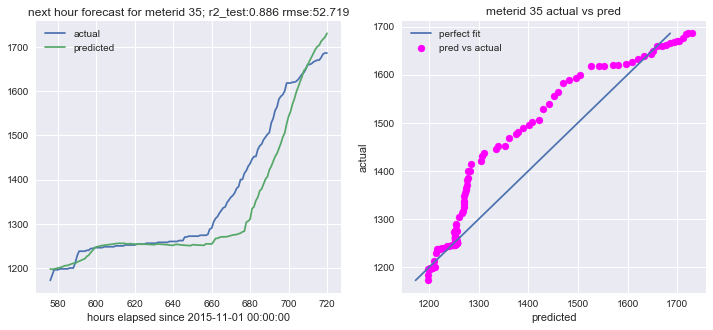

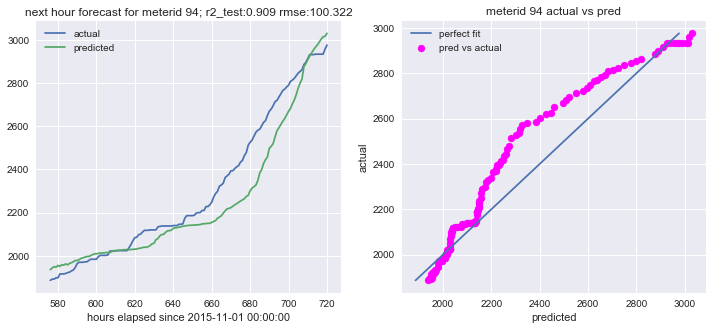

In [78]:
for meterid in [35, 94]:
    X, x_train, x_valid, x_test, y, y_train, y_valid, y_test = split_data(meterid=meterid)
    #model = Lasso(alpha=1e-4, max_iter = 1e6, tol = 0.0040)
    model = SVR(C=1159, gamma='scale', kernel='rbf')
    #model = LinearRegression()
    rmse, r2, preds = rolling_walk_forward_val(model, X, y, window_size=len(x_train)) # window_size=len(x_train) 

In [21]:
# rolling window walk forward validation:
def rolling_walk_forward_val_plusn(model, X, y, window_size=250):
    #window_size = 250
    predictions = []
    n = 100 # predict t+1+n into the future
    for i in range(0, len(X) - window_size - n):
        train_x, test_x = X[i:i+window_size], X[i+window_size:i+window_size+1+n]
        train_y, test_y = y[i:i+window_size], y[i+window_size:i+window_size+1+n]
        # train model, predict next timestep, record prediction
        model.fit(train_x, train_y)
        pred = model.predict(test_x)[0]
        predictions.append(pred)

    predictions_arr = np.asarray(predictions)

    # overall evaluation of model performance:
    # 1. correlation analysis of predicted vs actual?
    # 2. R^2 and RMSE
    # 3. plot residual and prediction error and observe.
    mse = mean_squared_error(y_true=y[window_size+n:], y_pred=predictions_arr)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_true=y[window_size+n:], y_pred=predictions_arr)
    
    # naive baseline prediction based on t-1
    #y_naive_base = np.roll(y[window_size:], shift=1)
    #y_naive_base[0] = y_naive_base[1]
    #r2base = r2_score(y_true=y[window_size:], y_pred=y_naive_base)
    
    plt.cla()
    plt.plot(X[window_size+n:], y[window_size+n:], label='actual')
    plt.plot(X[window_size+n:], predictions_arr, label='predicted')
    #plt.plot(X[window_size:], y_naive_base, label='baseline')

    plt.title(f'next {1+n}hour forecast for meterid {meterid}; r2:{r2:.3f} rmse:{rmse:.3f}')
    plt.xlabel(f'hours elapsed since {df_normalized["index"].iloc[0]}') 
    plt.legend()
    plt.show()
    return rmse, r2, predictions_arr

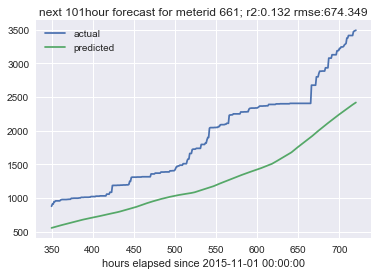

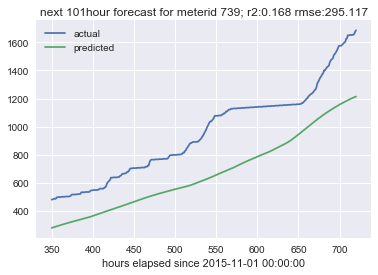

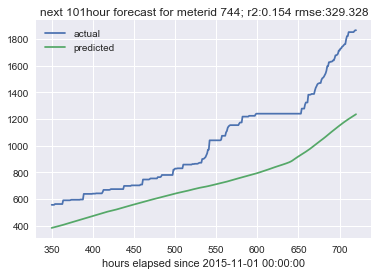

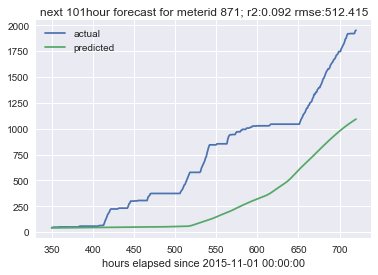

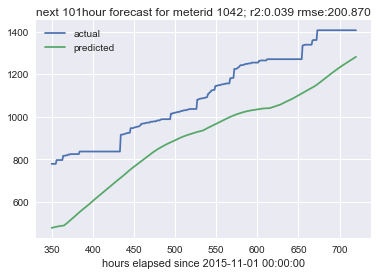

In [9]:
for meterid in [35, 94]:
    X, x_train, x_valid, x_test, y, y_train, y_valid, y_test = split_data(meterid=meterid)
    model = Lasso(alpha=1e-4, max_iter = 1e6, tol = 0.0040)
    #model = SVR(C=1159, gamma='scale', kernel='rbf')
    #model = LinearRegression()
    rmse, r2, preds = rolling_walk_forward_val_plusn(model, X, y, window_size=250)